In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
import os
from skimage import transform as trans

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, AtrousConvolution2D
from keras.models import Sequential, Model

from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util
from tensorflow import graph_util
import tensorflow as tf
import keras.backend as K

import sys
sys.path.append('./RetinaFace')
from retinaface import RetinaFace

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

/home/user/.local/lib/python3.5/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.
/home/user/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passin

### Load detection and align model

In [2]:
gpuid = -1
detector = RetinaFace('./RetinaFace/retinaface-R50/R50', 0, gpuid, 'net3')

[32, 16, 8] {'16': {'RATIOS': (1.0,), 'SCALES': (8, 4), 'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16}, '8': {'RATIOS': (1.0,), 'SCALES': (2, 1), 'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16}, '32': {'RATIOS': (1.0,), 'SCALES': (32, 16), 'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16}}
means [0. 0. 0.]
use_landmarks True
cascade 0
sym size: 9


In [3]:
minsize = 100 # minimum size of face
thresh = 0.8
scales = [1.0]
factor = 0.709 # scale factor
image_size = [256,256]
src = np.array([
  [30.2946, 51.6963],
  [65.5318, 51.5014],
  [48.0252, 71.7366],
  [33.5493, 92.3655],
  [62.7299, 92.2041] ], dtype=np.float32 )

src[:,0] += 8.0
src[:,0] += 15.0
src[:,1] += 30.0
src /= 112
src *= 200

In [4]:
def align_face(img):
    bounding_boxes, points = detector.detect(img, thresh, scales=scales, do_flip=False)
    white_image = np.ones(img.shape, dtype=np.uint8)*255

    result_faces = []
    result_masks = []
    result_matrix = []
    
    if bounding_boxes.shape[0]>0:
        det = bounding_boxes[:,0:4]
        for i in range(det.shape[0]):
            _det = det[i]
            dst = points[i]
            
            
            tform = trans.SimilarityTransform()
            tform.estimate(dst, src)
            M = tform.params[0:2,:]
            warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
            mask = cv2.warpAffine(white_image,M,(image_size[1],image_size[0]), borderValue = 0.0)
            
            result_faces.append(warped)
            result_masks.append(mask)
            result_matrix.append(tform.params[0:3,:])
            
    return result_faces, result_masks, result_matrix

In [5]:
def put_face_back(img, faces, masks, result_matrix):
    for i in range(len(faces)):
        M = np.linalg.inv(result_matrix[i])[0:2]
        warped = cv2.warpAffine(faces[i], M, (img.shape[1], img.shape[0]), borderValue = 0.0)
        mask = cv2.warpAffine(masks[i], M, (img.shape[1], img.shape[0]), borderValue = 0.0)
        mask = mask//255
        img = img * (1 - mask)
        img = img.astype(np.uint8)
        img += warped * mask
    return img

### Load GAN

In [6]:
def squeeze_excite_block(input, ratio=4):
    ''' Create a channel-wise squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

def conv2d(layer_input, filters, f_size=4, bn=True, se=False):
    """Layers used during downsampling"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = InstanceNormalization()(d)
    if se:
        d = squeeze_excite_block(d)
    return d

def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    u = InstanceNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u

def atrous(layer_input, filters, f_size=4, bn=True):
    a_list = []
    for rate in [2,4,8]:
        a = AtrousConvolution2D(filters, f_size, atrous_rate=rate, border_mode='same')(layer_input)
        a_list.append(a)
    a = Concatenate()(a_list)
    a = LeakyReLU(alpha=0.2)(a)
    if bn:
        a = InstanceNormalization()(a)
    return a

K.set_learning_phase(0)

# Image input
d0 = Input(shape=(256, 256, 3))

gf = 64
# Downsampling
d1 = conv2d(d0, gf, bn=False, se=True)
d2 = conv2d(d1, gf*2, se=True)
d3 = conv2d(d2, gf*4, se=True)
d4 = conv2d(d3, gf*8)
d5 = conv2d(d4, gf*8)

a1 = atrous(d5, gf*8)

# Upsampling
u3 = deconv2d(a1, d4, gf*8)
u4 = deconv2d(u3, d3, gf*4)
u5 = deconv2d(u4, d2, gf*2)
u6 = deconv2d(u5, d1, gf)

u7 = UpSampling2D(size=2)(u6)
output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

model = Model(d0, output_img)

/home/user/.local/lib/python3.5/site-packages/keras/legacy/layers.py:304: UserWarning: The `AtrousConvolution2D` layer  has been deprecated. Use instead the `Conv2D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution2D` layer '
/home/user/.local/lib/python3.5/site-packages/keras/legacy/layers.py:308: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, 4, dilation_rate=2, padding="same")`
  return Conv2D(*args, **kwargs)
/home/user/.local/lib/python3.5/site-packages/keras/legacy/layers.py:308: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, 4, dilation_rate=4, padding="same")`
  return Conv2D(*args, **kwargs)
/home/user/.local/lib/python3.5/site-packages/keras/legacy/layers.py:308: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, 4, dilation_rate=8, padding="same")`
  return Conv2D(*args, **kwargs)


In [7]:
model.load_weights('./saved_model/faces_bald_InsNorm_4x4_D2/model_G_5_170.hdf5')

### Test on image

In [8]:
def proc_files(filelist):
    global_result = None
    
    for filename in filelist:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces, masks, matrix = align_face(img)
        result_faces = []

        for i in range(len(faces)):
            face = faces[i]
            
            #face = cv2.ellipse(face, (128, 128), (128, 128), 
            #                   0, 180, 360, (0, 0, 0), -1) 
            
            input_face = np.expand_dims(face, axis=0)
            input_face = input_face / 127.5 - 1.
            result = model.predict(input_face)[0]
            result = ((result + 1.)*127.5)
            result = result.astype(np.uint8)
            result_faces.append(result)
        
        img_result = put_face_back(img, result_faces, masks, matrix)
        img_result = np.hstack([img, img_result])
        
        
        
        plt.figure(figsize=(9, 9))
        plt.axis('off')
        plt.imshow(img_result)
        plt.show()
    

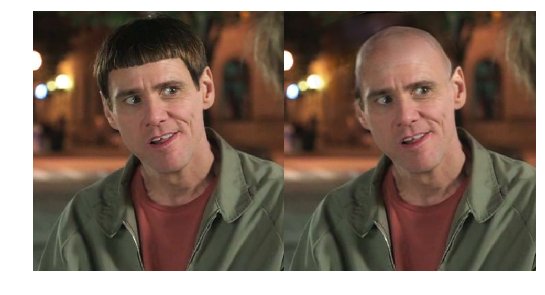

In [9]:
proc_files(['./examples/12.jpg'])